<a href="https://colab.research.google.com/github/CurlyNikolai/Citybike_ml/blob/main/city_bike_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# City Bike Machine Learning

Welcome to the city bike machine learning project!

This code was created for the Machine Learning course student project at Aalto University. The purpose of this study is to investigate whether a valuable model can be attained from the Helsinki Regional Transport Authority’s (HSL) city-bike data and weather observations provided by the Finnish Meteorogical Institute (FMI), in order to better anticipate the need for a redistribution of bicycles to a specific city-bike-station. 


Let's put all our required imports in here.

In [18]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures   # function to generate polynomial and interaction features
from sklearn.linear_model import LinearRegression    # classes providing Linear Regression with ordinary squared error loss and Huber loss, respectively
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.lines import Line2D
import calendar
int_to_weekday_map = {0 : "Mon", 1 : "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"}

## The Data

The original data can be found from the following links:
1. [HSL city-bike data](https://www.hsl.fi/en/hsl/open-data) (CC BY 4.0)
2. [FMI weather observations](https://en.ilmatieteenlaitos.fi/download-observations) (CC BY 4.0)

### Read in the data
Let's start of by reading in the modified data, and taking a little peek of it:

In [19]:
# Read in the data
data = pd.read_csv("bike_data.csv", index_col=0)
pd.set_option("expand_frame_repr", False)
data = data[data["Departures"]>0]
print(data.columns)
print(data.head)

Index(['Year', 'Month', 'Day', 'Hour', 'Date', 'Weekday', 'Departures',
       'Returns', 'Air temperature', 'Rain intensity', 'Rain intensity class'],
      dtype='object')
<bound method NDFrame.head of         Year  Month  Day  Hour   Date  Weekday  Departures  Returns  Air temperature  Rain intensity  Rain intensity class
468     2016      5    2    15  05-02        0         4.0      2.0             15.5             0.0                   0.0
469     2016      5    2    15  05-02        0         4.0      2.0             15.5             0.0                   0.0
480     2016      5    2    16  05-02        0         2.0      2.0             15.3             0.0                   0.0
481     2016      5    2    16  05-02        0         2.0      2.0             15.3             0.0                   0.0
492     2016      5    2    17  05-02        0         2.0      3.0             12.6             0.0                   0.0
...      ...    ...  ...   ...    ...      ...         ...

Then let's further modify our data, by including annually normalized departures and returns, and a classifier for if it's a working day or weekend.

In [20]:
# Add normalized departure and return data (normalize by annual max)

# Normalize departures
yearly_max = data.groupby(["Year"]).Departures.max()
years = yearly_max.index.to_numpy()
maxval = yearly_max.values
yearly_max = pd.DataFrame(data={"Year": years, "Maxvalue": maxval})
data = data.merge(yearly_max, on=["Year"])
data["Normalized departures"] = data.Departures / data.Maxvalue
data.drop(['Maxvalue'], axis=1, inplace=True)

# Normalize returns
yearly_max = data.groupby(["Year"]).Returns.max()
years = yearly_max.index.to_numpy()
maxval = yearly_max.values
yearly_max = pd.DataFrame(data={"Year": years, "Maxvalue": maxval})
data = data.merge(yearly_max, on=["Year"])
data["Normalized returns"] = data.Returns / data.Maxvalue
data.drop(['Maxvalue'], axis=1, inplace=True)

# Add classifier for the weekday to specify between workday and weekend (0, 1)
data["Weekday classifier"] = np.where(data.Weekday < 5, 0, 1)

# Reorder the columns
data = data[["Year", "Month", "Day", "Hour", "Date", "Weekday", "Weekday classifier", "Departures", "Returns",
             "Normalized departures", "Normalized returns", "Air temperature", "Rain intensity", "Rain intensity class"]]

# Sanity check, look at the data
print(data.head)


<bound method NDFrame.head of        Year  Month  Day  Hour   Date  Weekday  Weekday classifier  Departures  Returns  Normalized departures  Normalized returns  Air temperature  Rain intensity  Rain intensity class
0      2016      5    2    15  05-02        0                   0         4.0      2.0               0.142857            0.086957             15.5             0.0                   0.0
1      2016      5    2    15  05-02        0                   0         4.0      2.0               0.142857            0.086957             15.5             0.0                   0.0
2      2016      5    2    16  05-02        0                   0         2.0      2.0               0.071429            0.086957             15.3             0.0                   0.0
3      2016      5    2    16  05-02        0                   0         2.0      2.0               0.071429            0.086957             15.3             0.0                   0.0
4      2016      5    2    17  05-02        0

### Data visualization

Next, let's visualize the data by plotting the number of departures against most features:

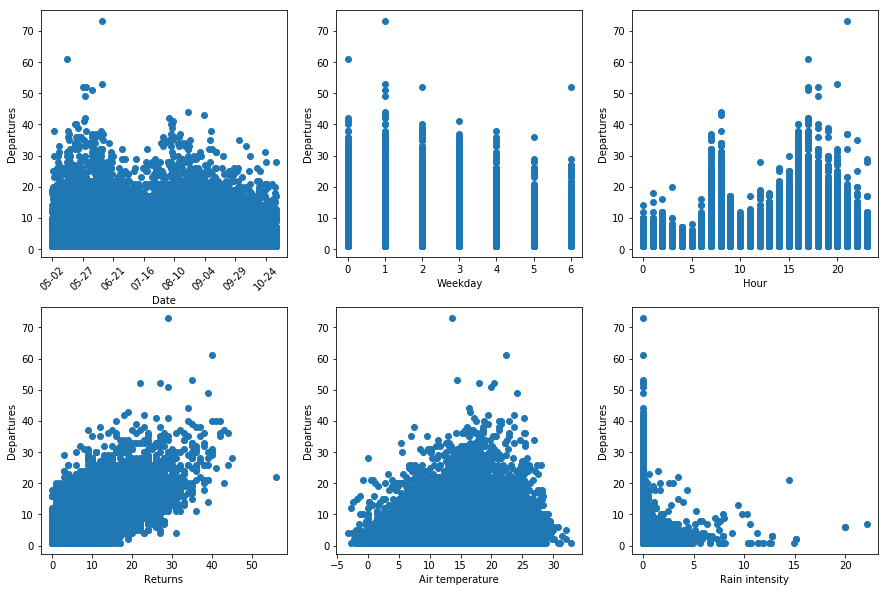

In [21]:
# Plot departures against Hour, Air temperature, Rain intensity, Weekday
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15), fig.set_figheight(10)
axs[0, 0].scatter(data.Date, data.Departures)
axs[0, 0].xaxis.set_major_locator(ticker.MaxNLocator(10))
axs[0, 0].set_ylabel("Departures")
axs[0, 0].set_xlabel("Date")
for tick in axs[0, 0].get_xticklabels(): tick.set_rotation(45)
axs[0, 1].scatter(data.Weekday, data.Departures)
axs[0, 1].set_ylabel("Departures")
axs[0, 1].set_xlabel("Weekday")
axs[0, 2].scatter(data.Hour, data.Departures)
axs[0, 2].set_ylabel("Departures")
axs[0, 2].set_xlabel("Hour")
axs[1, 0].scatter(data.Returns, data.Departures)
axs[1, 0].set_ylabel("Departures")
axs[1, 0].set_xlabel("Returns")
axs[1, 1].scatter(data["Air temperature"], data.Departures)
axs[1, 1].set_ylabel("Departures")
axs[1, 1].set_xlabel("Air temperature")
axs[1, 2].scatter(data["Rain intensity"], data.Departures)
axs[1, 2].set_ylabel("Departures")
axs[1, 2].set_xlabel("Rain intensity")
plt.show()

Then, let's add some transparency to better see the density of the datapoints, and colour depending on the rain intensity class:

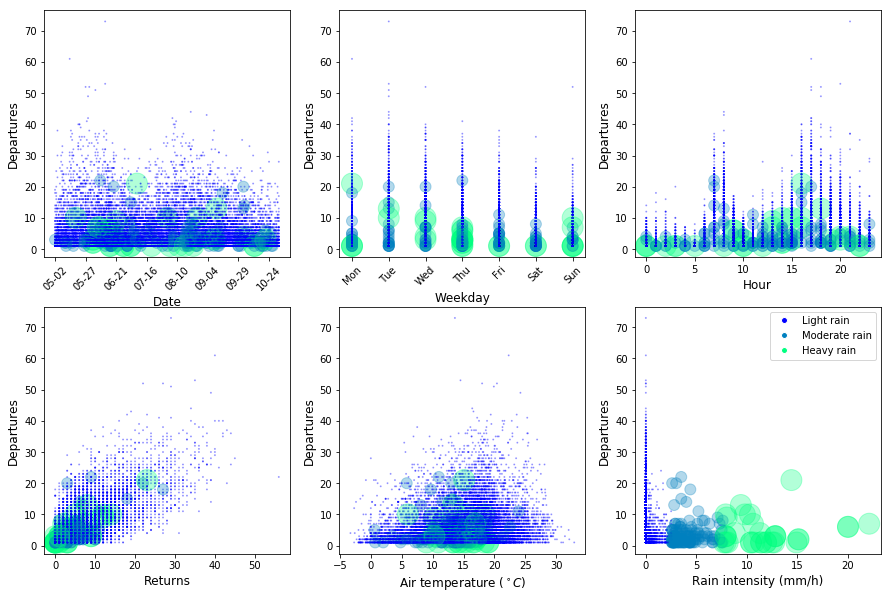

In [22]:
# Plot departures against Hour, Air temperature, Rain intensity, Weekday
fontsize = 12
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15), fig.set_figheight(10)
axs[0, 0].scatter(data.Date, data.Departures, s=100*(data["Rain intensity class"]+0.1)**2, alpha=0.3, c=data["Rain intensity class"], cmap='winter')
axs[0, 0].xaxis.set_major_locator(ticker.MaxNLocator(10))
axs[0, 0].set_ylabel("Departures", fontsize=fontsize)
axs[0, 0].set_xlabel("Date", fontsize=fontsize)
for tick in axs[0, 0].get_xticklabels(): tick.set_rotation(45)
axs[0, 1].scatter(data.Weekday, data.Departures, s=100*(data["Rain intensity class"]+0.1)**2, alpha=0.3, c=data["Rain intensity class"], cmap='winter')
axs[0, 1].set_ylabel("Departures", fontsize=fontsize)
axs[0, 1].set_xlabel("Weekday", fontsize=fontsize)
axs[0, 1].set_xticks([i for i in range(7)])
axs[0, 1].set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
for tick in axs[0, 1].get_xticklabels(): tick.set_rotation(45)
axs[0, 2].scatter(data.Hour, data.Departures, s=100*(data["Rain intensity class"]+0.1)**2, alpha=0.3, c=data["Rain intensity class"], cmap='winter')
axs[0, 2].set_ylabel("Departures", fontsize=fontsize)
axs[0, 2].set_xlabel("Hour", fontsize=fontsize)
axs[1, 0].scatter(data.Returns, data.Departures, s=100*(data["Rain intensity class"]+0.1)**2, alpha=0.3, c=data["Rain intensity class"], cmap='winter')
axs[1, 0].set_ylabel("Departures", fontsize=fontsize)
axs[1, 0].set_xlabel("Returns", fontsize=fontsize)
axs[1, 1].scatter(data["Air temperature"], data.Departures, s=100*(data["Rain intensity class"]+0.1)**2, alpha=0.3, c=data["Rain intensity class"], cmap='winter')
axs[1, 1].set_ylabel("Departures", fontsize=fontsize)
axs[1, 1].set_xlabel("Air temperature ($^\circ C$)", fontsize=fontsize)
axs[1, 2].scatter(data["Rain intensity"], data.Departures, s=100*(data["Rain intensity class"]+0.1)**2, alpha=0.3, c=data["Rain intensity class"], cmap='winter')
axs[1, 2].set_ylabel("Departures", fontsize=fontsize)
axs[1, 2].set_xlabel("Rain intensity (mm/h)", fontsize=fontsize)
cmap=plt.cm.winter
custom_markers = [Line2D([0], [0], color="w", markerfacecolor=cmap(0.0), marker='o'),
                  Line2D([0], [0], color="w", markerfacecolor=cmap(0.5), marker='o'),
                  Line2D([0], [0], color="w", markerfacecolor=cmap(1.0), marker='o')]
axs[1, 2].legend(custom_markers, ["Light rain", "Moderate rain", "Heavy rain"])
plt.savefig("data-summary.jpg", dpi=300, bbox_inches='tight')
plt.show()


Let's now instead colour the datapoints depending on the air temperature:

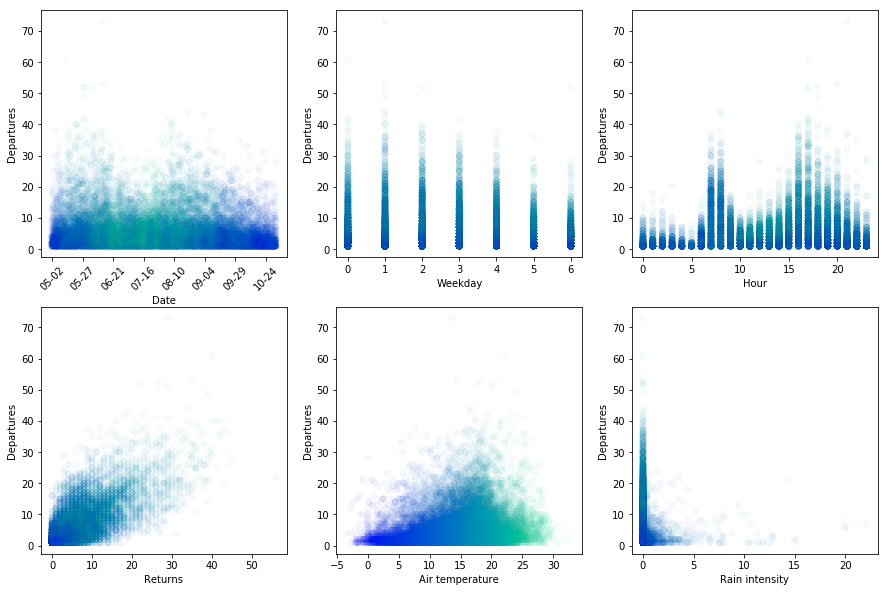

In [23]:
# Plot departures against Hour, Air temperature, Rain intensity, Weekday
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15), fig.set_figheight(10)
axs[0, 0].scatter(data.Date, data.Departures, alpha=0.03, c=data["Air temperature"], cmap='winter')
axs[0, 0].xaxis.set_major_locator(ticker.MaxNLocator(10))
axs[0, 0].set_ylabel("Departures")
axs[0, 0].set_xlabel("Date")
for tick in axs[0, 0].get_xticklabels(): tick.set_rotation(45)
axs[0, 1].scatter(data.Weekday, data.Departures, alpha=0.03, c=data["Air temperature"], cmap='winter')
axs[0, 1].set_ylabel("Departures")
axs[0, 1].set_xlabel("Weekday")
axs[0, 2].scatter(data.Hour, data.Departures, alpha=0.03, c=data["Air temperature"], cmap='winter')
axs[0, 2].set_ylabel("Departures")
axs[0, 2].set_xlabel("Hour")
axs[1, 0].scatter(data.Returns, data.Departures, alpha=0.03, c=data["Air temperature"], cmap='winter')
axs[1, 0].set_ylabel("Departures")
axs[1, 0].set_xlabel("Returns")
axs[1, 1].scatter(data["Air temperature"], data.Departures, alpha=0.03, c=data["Air temperature"], cmap='winter')
axs[1, 1].set_ylabel("Departures")
axs[1, 1].set_xlabel("Air temperature")
axs[1, 2].scatter(data["Rain intensity"], data.Departures, alpha=0.03, c=data["Air temperature"], cmap='winter')
axs[1, 2].set_ylabel("Departures")
axs[1, 2].set_xlabel("Rain intensity")
plt.show()


Let's also see how the mean amount of departures has changed throughout the years:

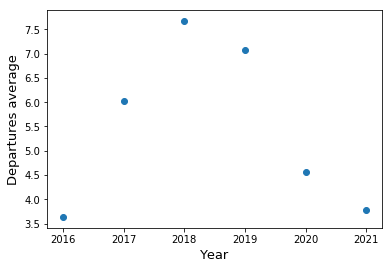

In [24]:
# Cell for investigating the popularity of bikes at Kaisaniemi, depending on year, and weekday on different years

data_grouped_mean = data.groupby(["Year"]).Departures.mean()
year = data_grouped_mean.index.to_numpy()
value = data_grouped_mean[year].values
plt.scatter(year, value)
plt.xlabel(r"Year", fontsize=13)
plt.ylabel(r"Departures average", fontsize=13)
plt.savefig("Covid_effect.jpg", dpi=300, bbox_inches='tight')
plt.show()

Covid unveils its ugly head here as well 👆

Let's now plot the departures against the hour of day, for every weekday:

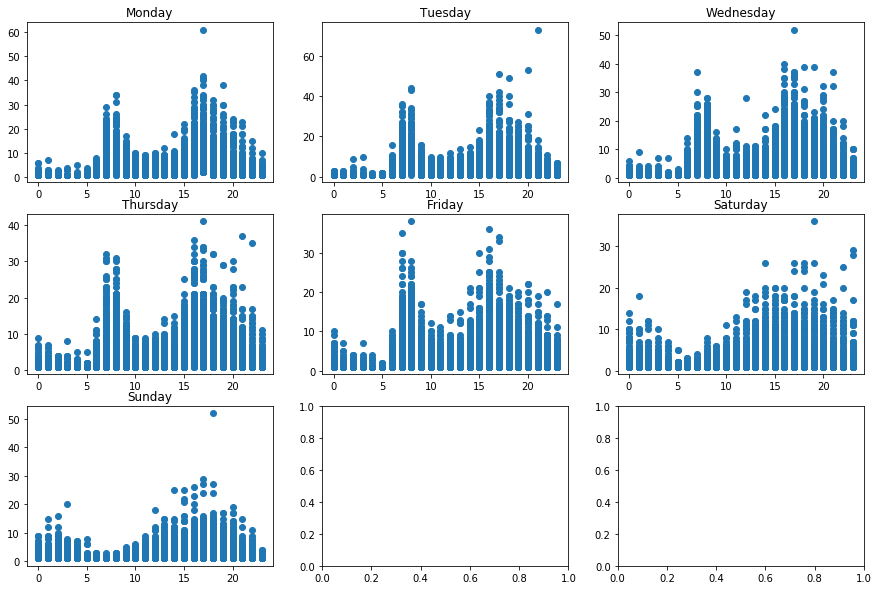

In [25]:
# Separate data into weekday data
data_weekday = [data[data.Weekday == i] for i in range(7)]

# Plot the departures for every hour, for every weekday
fig, axs = plt.subplots(3,3)
fig.set_figwidth(15); fig.set_figheight(10)
j, k = 0, 0
for i in range(7):
    if k==3: k = 0; j += 1
    axs[j, k].scatter(data_weekday[i].Hour, data_weekday[i].Departures)
    axs[j, k].set_title(list(calendar.day_name)[i])
    k+=1
plt.show()


What's interesting to see in the plot above is that we can clearly distuingish rush hours during the weekdays, and what's even more interesting to see is the little bump in departures during the night at the end of the week 😊

Let's separate the days into working days and weekends:

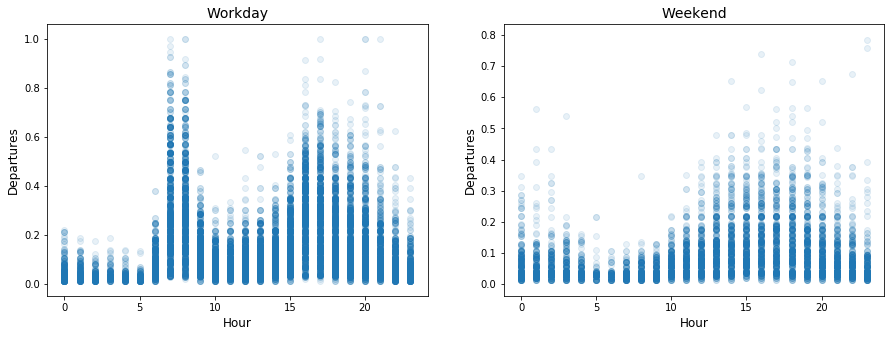

In [26]:
# Separate data into weekday data
data_weekday = [data[data["Weekday classifier"] == i] for i in range(2)]

# Plot the departures for every hour, for every weekday
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.set_figheight(5)
j, k = 0, 0
for i in range(2):
    axs[i].scatter(data_weekday[i].Hour, data_weekday[i]["Normalized departures"], alpha=0.1)
    axs[i].set_xlabel("Hour", fontsize=12)
    axs[i].set_ylabel("Departures", fontsize=12)
axs[0].set_title("Workday", fontsize=14)
axs[1].set_title("Weekend", fontsize=14)
plt.savefig("departures-all.jpg", dpi=300, bbox_inches='tight')
plt.show()


## Polynomial Regression

Let's try out different degrees for polynomial regression on the upper contour of the departures data for workdays and weekends, storing the training and validation errors:

In [27]:
# Do the same thing as above, but split days into two categories: workday and weekend (0 and 1)

# Polynomial fit for the data where only the 20 max departure datapoints are taken into account for each hour during each weekday
nlargest = 20

data_largest = data.groupby(["Weekday classifier", "Hour"])[
    "Normalized departures"].nlargest(20)

tr_errors = {0 : [], 1 : []}
val_errors = {0: [], 1: []}
for deg in range(0, 15):
    # fig, axs = plt.subplots(1, 2)
    # fig.set_figwidth(15)
    # fig.set_figheight(5)
    for day in range(2):
        y = data_largest[day].values
        X = data_largest[day].index.get_level_values(0).to_numpy().reshape(-1, 1)
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
        
        poly = PolynomialFeatures(degree=deg)
        X_train_poly = poly.fit_transform(X_train)

        lin_regr = LinearRegression(fit_intercept=False)
        lin_regr.fit(X_train_poly, y_train)

        y_pred_train = lin_regr.predict(X_train_poly)
        tr_error = mean_squared_error(y_train, y_pred_train)
        tr_errors[day].append(tr_error)

        X_val_poly = poly.fit_transform(X_val)
        y_pred_val = lin_regr.predict(X_val_poly)
        val_error = mean_squared_error(y_val, y_pred_val)
        val_errors[day].append(val_error)

        X_fit = np.linspace(0, 23, 24)    # generate samples

        title = ""
        if day == 0:
            title = "Workday"
        else:
            title = "Weekend"

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        text_str = "Degree: {:d}".format(deg) + "\nTraining error: {:.6f}".format(tr_error) + "\nValidation error: {:.6f}".format(val_error)
        # axs[day].text(0.55, 0.15, text_str, transform=axs[day].transAxes, fontsize=10, verticalalignment="top", bbox=props)

        # axs[day].scatter(X_train, y_train, color="#88CCEE", label="Training data")
        # axs[day].scatter(X_val, y_val, s=5, color="#332288", label="Validation data")
        # axs[day].set_title(title)
        # axs[day].scatter(X_fit, lin_regr.predict(poly.transform(
        #     X_fit.reshape(-1, 1))), color="#882255", 
        #     label="Model")
        # axs[day].legend(loc='upper left', prop={'size' : 10})
        # axs[day].set_ylim(-0.1, 1.1)

    # plt.show()


Then let's plot the training and validation errors:

15 2 2


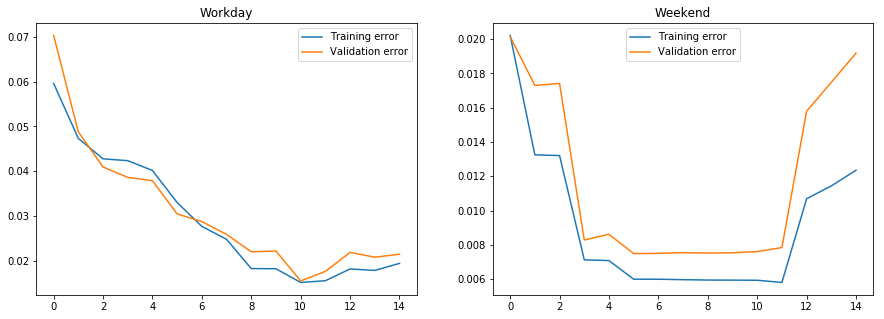

In [28]:
# Plot the training and validation errors

y = [deg for deg in range(15)]
print(len(y), len(tr_errors), len(val_errors))
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.set_figheight(5)

axs[0].set_title("Workday")
axs[1].set_title("Weekend")
axs[0].plot(y, tr_errors[0], label="Training error")
axs[0].plot(y, val_errors[0], label="Validation error")
axs[1].plot(y, tr_errors[1], label="Training error")
axs[1].plot(y, val_errors[1], label="Validation error")
axs[0].legend()
axs[1].legend()
plt.savefig("poly_tr_val_error.jpg", dpi=300, bbox_inches="tight")
plt.show()


Looks like a degree of 10 is good for the workdays, while a degree of 5 is sufficient for the weekends. 

Let's plot these models, both on the training and validation data:

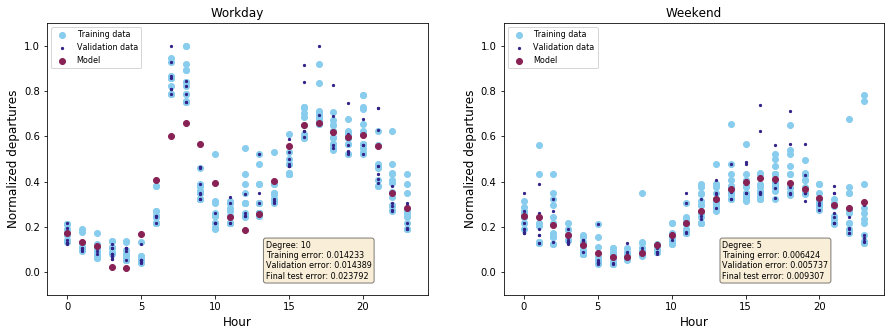

In [38]:
# Do the same thing as above, but split days into two categories: workday and weekend (0 and 1)

# Polynomial fit for the data where only the 10 max departure datapoints are taken into account for each hour during each weekday

nlargest = 20
data_largest = data.groupby(["Weekday classifier", "Hour"])["Normalized departures"].nlargest(nlargest)

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.set_figheight(5)
for day in range(2):

    # Read in the data for polynomial regression
    y = data_largest[day].values
    X = data_largest[day].index.get_level_values(0).to_numpy().reshape(-1, 1)

    # Split data into training, validation and testing sets
    X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.25, random_state=42)

    # Check whether it's a workday or weekday
    title = ""
    if day == 0:
        title = "Workday"
        deg = 10
    else:
        title = "Weekend"
        deg = 5

    poly = PolynomialFeatures(degree=deg)


    # Train the model
    X_train_poly = poly.fit_transform(X_train)
    lin_regr = LinearRegression(fit_intercept=False)
    lin_regr.fit(X_train_poly, y_train)
    y_pred_train = lin_regr.predict(X_train_poly)
    tr_error = mean_squared_error(y_train, y_pred_train)

    # Validate the model
    X_val_poly = poly.fit_transform(X_val)
    y_pred_val = lin_regr.predict(X_val_poly)
    val_error = mean_squared_error(y_val, y_pred_val)

    # Test the model
    X_test_poly = poly.fit_transform(X_test)
    y_pred_test = lin_regr.predict(X_test_poly)
    test_error = mean_squared_error(y_test, y_pred_test)

    
    # The plot thickens
    X_fit = np.linspace(0, 23, 24) 
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    text_str = "Degree: {:d}".format(deg) + "\nTraining error: {:.6f}".format(
        tr_error) + "\nValidation error: {:.6f}".format(val_error) + "\nFinal test error: {:.6f}".format(test_error)
    axs[day].text(0.575, 0.2, text_str, transform=axs[day].transAxes,
                    fontsize=8, verticalalignment="top", bbox=props)

    axs[day].scatter(X_train, y_train, color="#88CCEE", label="Training data")
    axs[day].scatter(X_val, y_val, s=5, color="#332288", label="Validation data")
    axs[day].set_title(title)
    axs[day].scatter(X_fit, lin_regr.predict(poly.transform(X_fit.reshape(-1, 1))), color="#882255",label="Model")
    axs[day].legend(loc='upper left', prop={'size': 8})
    axs[day].set_ylim(-0.1, 1.1)

    y = data[data["Weekday classifier"] ==day]["Normalized departures"].to_numpy()
    X = data[data["Weekday classifier"]==day].Hour.to_numpy().reshape(-1,1)

axs[0].set_ylabel("Normalized departures", fontsize=12)
axs[1].set_ylabel("Normalized departures", fontsize=12)
axs[0].set_xlabel("Hour", fontsize=12)
axs[1].set_xlabel("Hour", fontsize=12)

plt.savefig("polynomial-result.jpg", dpi=300, bbox_inches="tight")
plt.show()


Looks good! The model follows the data quite nicely!


The following is just some additional K-Fold testing to reassure that the chosen degrees were alright.

In [42]:
# Polynomial fit for the data where only the 20 max departure datapoints are taken into account for each hour during each weekday
nlargest = 20

data_largest = data.groupby(["Weekday classifier", "Hour"])[
    "Normalized departures"].nlargest(nlargest)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

tr_errors = {"Workday": {}, "Weekend": {}}
val_errors = {"Workday": {}, "Weekend": {}}
for deg in range(0, 15):
    for day in range(2):

        title = ""
        if day == 0:
            title = "Workday"
        else:
            title = "Weekend"

        tr_errors[title][deg] = []
        val_errors[title][deg] = []
        

        # Read in the data for polynomial regression
        y = data_largest[day].values
        X = data_largest[day].index.get_level_values(0).to_numpy().reshape(-1, 1)

        for train_index, val_index in kfold.split(y):
            # Split data into training, validation and testing sets
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            poly = PolynomialFeatures(degree=deg)
            X_train_poly = poly.fit_transform(X_train)

            lin_regr = LinearRegression(fit_intercept=False)
            lin_regr.fit(X_train_poly, y_train)

            y_pred_train = lin_regr.predict(X_train_poly)
            tr_error = mean_squared_error(y_train, y_pred_train)
            tr_errors[title][deg].append(tr_error)

            X_val_poly = poly.fit_transform(X_val)
            y_pred_val = lin_regr.predict(X_val_poly)
            val_error = mean_squared_error(y_val, y_pred_val)
            val_errors[title][deg].append(val_error)


[0.06303360155336199, 0.0476891934550702, 0.042095675855200354, 0.040807520572949854, 0.03899521786830779, 0.0319698094195683, 0.02764983689802971, 0.024767658602430024, 0.019106258987869988, 0.019087387712271187, 0.0149881086798546, 0.01580199738068077, 0.018990017709214706, 0.019027096447364587, 0.01969754156209832]
[0.020189058743004265, 0.014401588942869975, 0.014376268726150634, 0.007409296054812014, 0.007398425631491961, 0.00631150681243897, 0.006308022105122227, 0.006288351989693236, 0.006256892933995136, 0.006251455473746484, 0.006246861471601711, 0.006215408372567117, 0.012093063040656658, 0.013724529242051715, 0.014363500914166997]
[0.06324891189571244, 0.0479458775640552, 0.04243132822417357, 0.04121820761123905, 0.03935275760010451, 0.03245753885184476, 0.028241008211914376, 0.02538632210455526, 0.01967393576910494, 0.019818050610900893, 0.015710222445980946, 0.01658617459746529, 0.01976871695552511, 0.019942325747422836, 0.02042156016424055]
[0.020222391822399606, 0.014539

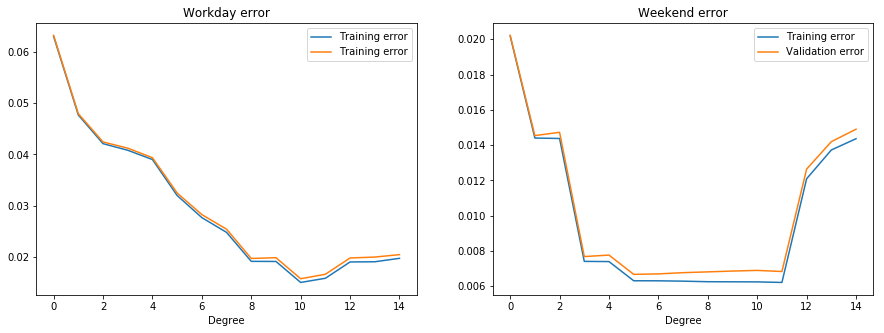

In [43]:
tr_error_workday_avg, tr_error_weekend_avg = [], []
val_error_workday_avg, val_error_weekend_avg = [], []

for deg in range(0, 15):
    tr_error_workday_avg.append(np.mean(tr_errors["Workday"][deg]))
    tr_error_weekend_avg.append(np.mean(tr_errors["Weekend"][deg]))

    val_error_workday_avg.append(np.mean(val_errors["Workday"][deg]))
    val_error_weekend_avg.append(np.mean(val_errors["Weekend"][deg]))

print(tr_error_workday_avg)
print(tr_error_weekend_avg)
print(val_error_workday_avg)
print(val_error_weekend_avg)


fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.set_figheight(5)

axs[0].plot(tr_error_workday_avg, label="Training error")
axs[0].plot(val_error_workday_avg, label="Training error")
axs[0].legend()
axs[0].set_title("Workday error")
axs[1].plot(tr_error_weekend_avg, label="Training error")
axs[1].plot(val_error_weekend_avg, label="Validation error")
axs[1].set_title("Weekend error")
axs[0].set_xlabel("Degree")
axs[1].set_xlabel("Degree")
axs[1].legend()
plt.savefig("poly_kfold.jpg", dpi=300, bbox_inches="tight")
plt.show()


## Multilayered Perceptron

Now that we've managed to model the departures based on hour of day with polynomial regression, let's crank up the complexity with weather observations. We'll be adding the rain intensity classifier and train a multilayered perceptron so that the weekday classifier, hour of day and rain intensity works as features. The label is still the annualy normalized number of departures. Let's plot the data separately for workdays and weekdays, and add a colour mapping based on rain. 

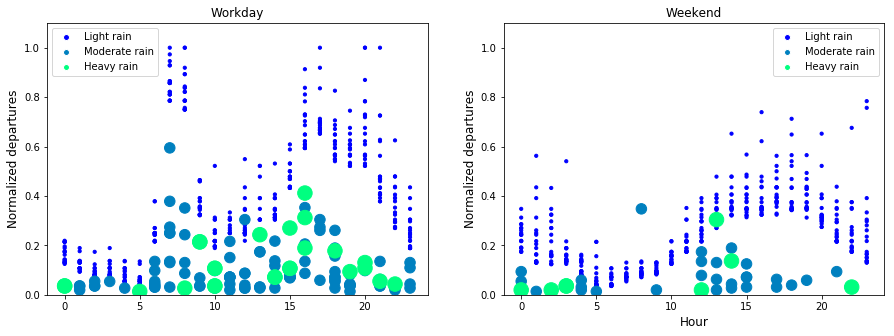

In [33]:
data_2 = data[["Hour", "Weekday classifier", "Normalized departures", "Rain intensity class"]]
nlargest = 20
data_largest = data_2.groupby(["Weekday classifier", "Hour", "Rain intensity class"])["Normalized departures"].nlargest(nlargest)
y = data_largest.values
X_0 = data_largest.index.get_level_values(0).to_numpy().reshape(-1,1)
X_1 = data_largest.index.get_level_values(1).to_numpy().reshape(-1,1)
X_2 = data_largest.index.get_level_values(2).to_numpy().reshape(-1,1)
X = np.hstack((X_0, X_1, X_2))
mask_weekday = (X[:, 0] == 0)
mask_weekend = (X[:, 0] == 1)

fig, axs = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(5)
axs[0].scatter(X[:, 1][mask_weekday], y[mask_weekday], s=100*(X[:,2][mask_weekday]+0.1), c=X[:,2][mask_weekday], cmap='winter')
axs[1].scatter(X[:, 1][mask_weekend], y[mask_weekend], s=100*(X[:,2][mask_weekend]+0.1), c=X[:,2][mask_weekend], cmap='winter')
axs[0].set_ylabel("Normalized departures", fontsize=12)
axs[1].set_ylabel("Normalized departures", fontsize=12)
axs[1].set_xlabel("Hour", fontsize=12)
axs[0].set_title("Workday", fontsize=12)
axs[1].set_title("Weekend", fontsize=12)
axs[0].set_ylim(0.0, 1.1)
axs[1].set_ylim(0.0, 1.1)
cmap = plt.cm.winter
custom_markers = [Line2D([0], [0], color="w", markerfacecolor=cmap(0.0), marker='o'),
                  Line2D([0], [0], color="w",
                         markerfacecolor=cmap(0.5), marker='o'),
                  Line2D([0], [0], color="w", markerfacecolor=cmap(1.0), marker='o')]
axs[0].legend(custom_markers, ["Light rain", "Moderate rain", "Heavy rain"])
axs[1].legend(custom_markers, ["Light rain", "Moderate rain", "Heavy rain"])
plt.show()


We can see at least for the workday that the additionial higher intensity rain data follows somewhat the overall trend, albeit suppressed. 

Let's then train several mlp:s on this data, for different numbers of hidden layers. The number of neurons were chosen to be 15 for each layer. This decision was made on some tinkering/experimentation with different combinations of neurons.

Let's also plot the resulting training and validation errors to see how many hidden layers are sufficient. 

[0.03127775226147973, 0.019419099493027836, 0.02132120512820297, 0.006279014056490849, 0.018020341298510694, 0.018671684430699463, 0.006203241333199619, 0.005687465608614166, 0.006518444618290422, 0.006739211581130556, 0.00560732149291137, 0.018932331018717143, 0.007893705491291755, 0.007869678276973052, 0.005598266525014637, 0.006253385844221879, 0.007028148814781979, 0.00563222388920566, 0.005888231092173027, 0.0069295544841905116, 0.04635149558169551, 0.046318063796121405, 0.04635978732037251, 0.04636280203501336, 0.04635385092616275]
[0.029758213391106476, 0.020373105520257978, 0.02036297345214887, 0.007355529559323566, 0.017997470508708677, 0.019043114436273868, 0.0076023095745694925, 0.007259739362690502, 0.007708638498472804, 0.007861964205826612, 0.007532641724876617, 0.01909813852920891, 0.009251969396449117, 0.00907247813450739, 0.007118254640910742, 0.007296936726423642, 0.007489914751395359, 0.007188130679551154, 0.007265488067247988, 0.007620903500954683, 0.049324644402268

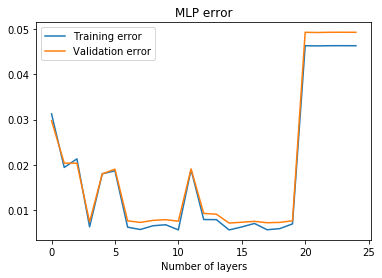

In [34]:
# Features X: weekday classifier, hour, rain intensity classifier
# Label y: Normalized departures
#print(X) 
#print(y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

num_layers = [i for i in range(25)]
num_neurons = 15

tr_errors = []
val_errors = []

for i, num in enumerate(num_layers):
       mlp_regr = MLPRegressor(hidden_layer_sizes=tuple([num_neurons] * num), solver='lbfgs', activation='relu', max_iter=5000, random_state=42)
       mlp_regr.fit(X_train, y_train)

       y_pred_train = mlp_regr.predict(X_train)
       tr_error = mean_squared_error(y_train, y_pred_train)
       y_pred_val = mlp_regr.predict(X_val)
       val_error = mean_squared_error(y_val, y_pred_val)

       tr_errors.append(tr_error)
       val_errors.append(val_error)

print(tr_errors)
print(val_errors)
plt.plot(num_layers, tr_errors, label="Training error")
plt.plot(num_layers, val_errors, label="Validation error")
plt.title("MLP error")
plt.xlabel("Number of layers")
plt.legend()
plt.savefig("mlp_tr_val_error.jpg", dpi=300, bbox_inches="tight")
plt.show()


From the plot we can see that maybe 7 layers are fine. The peaks around are a bit concerning though, so let's do some additional K-Folding here as well to make sure. 

[0.10289344184515717, 0.0476002703698221, 0.020812751245102765, 0.01933802286574743, 0.015485761016747363, 0.005187577844616874, 0.0043001374559573, 0.004357032494750795, 0.00784479534004045, 0.002999034870122998, 0.008799050258867116, 0.003122631613804379, 0.002839540412395725, 0.0025641795185270947, 0.002771810834182004, 0.003012301921968477, 0.0020353403803361997, 0.002661387403298798, 0.00496040740635324, 0.006517892217940811, 0.005612393938066498, 0.010670052421413069, 0.010206827495829936, 0.009779587626977749]
[0.11026813194138904, 0.04895647331192533, 0.02122460387595553, 0.019981217425005852, 0.016105100409261646, 0.005894905185985645, 0.004893623226888458, 0.004795950527877729, 0.008326890293202948, 0.00325096650221036, 0.00924484885250566, 0.0032451621377673034, 0.0029445963869329335, 0.0027233433133243582, 0.0030582661129529786, 0.004767033021556977, 0.00210526400415413, 0.0027998836220631865, 0.005429735201263412, 0.006122064884294424, 0.005794561701215227, 0.0106889467400

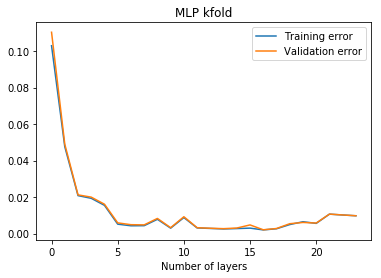

In [35]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

num_layers = [i for i in range(1, 25)]
num_neurons = 15

tr_errors = []
val_errors = []

for num in num_layers:

    tr_mean = 0
    val_mean = 0
    for train_index, val_index in kfold.split(y):
        # Split data into training, validation and testing sets
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        network = [num_neurons] * num
        mlp_regr = MLPRegressor(hidden_layer_sizes=tuple(network), solver='lbfgs', activation='relu', max_iter=5000, random_state=42)
        mlp_regr.fit(X_train, y_train)

        y_pred_train = mlp_regr.predict(X_train)
        tr_error = mean_squared_error(y_train, y_pred_train)

        y_pred_val = mlp_regr.predict(X_val)
        val_error = mean_squared_error(y_val, y_pred_val)

        tr_mean += tr_error
        val_mean += val_error


    tr_errors.append(tr_mean / len(network))
    val_errors.append(val_mean / len(network))

print(tr_errors)
print(val_errors)
print(network[6])

plt.plot(tr_errors, label="Training error")
plt.plot(val_errors, label="Validation error")
plt.title("MLP kfold")
plt.xlabel("Number of layers")
plt.legend()
plt.savefig("mlp_kfold.jpg", dpi=300, bbox_inches="tight")
plt.show()


So it seems that 7 layers should be sufficient to train on.

In the following cell we will train the model, and plot it based on the input data. 

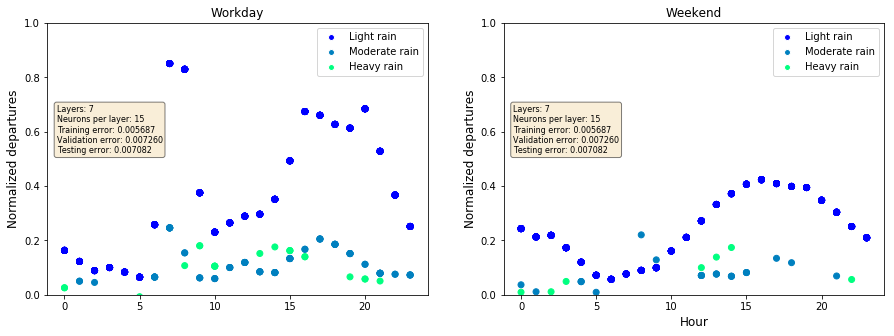

In [36]:
# Features X: weekday classifier, hour, rain intensity classifier
# Label y: Normalized departures
#print(X)
#print(y)

# Split data into training, validation and testing sets
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.25, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

num_layers = 7
num_neurons = 15


mlp_regr = MLPRegressor(hidden_layer_sizes=tuple([num_neurons] * num_layers), solver='lbfgs', activation='relu', max_iter=5000, random_state=42)
mlp_regr.fit(X_train, y_train)

#Training
y_pred_train = mlp_regr.predict(X_train)
tr_error = mean_squared_error(y_train, y_pred_train)

#Validation
y_pred_val = mlp_regr.predict(X_val)
val_error = mean_squared_error(y_val, y_pred_val)

#Testing
y_pred_test = mlp_regr.predict(X_test)
test_error = mean_squared_error(y_test, y_pred_test)

mask_weekday = (X_train[:, 0] == 0)
mask_weekend = (X_train[:, 0] == 1)
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.set_figheight(5)
axs[0].scatter(X_train[:, 1][mask_weekday], y_pred_train[mask_weekday], c=X_train[:, 2][mask_weekday], cmap='winter')
axs[1].scatter(X_train[:, 1][mask_weekend], y_pred_train[mask_weekend], c=X_train[:, 2][mask_weekend], cmap='winter')
axs[0].set_ylabel("Normalized departures", fontsize=12)
axs[1].set_ylabel("Normalized departures", fontsize=12)
axs[1].set_xlabel("Hour", fontsize=12)
axs[0].set_title("Workday", fontsize=12)
axs[1].set_title("Weekend", fontsize=12)
axs[0].set_ylim(0.0, 1.0)
axs[1].set_ylim(0.0, 1.0)

cmap = plt.cm.winter
custom_markers = [Line2D([0], [0], color="w", markerfacecolor=cmap(0.0), marker='o'),
                  Line2D([0], [0], color="w",
                         markerfacecolor=cmap(0.5), marker='o'),
                  Line2D([0], [0], color="w", markerfacecolor=cmap(1.0), marker='o')]
axs[0].legend(custom_markers, ["Light rain", "Moderate rain", "Heavy rain"])
axs[1].legend(custom_markers, ["Light rain", "Moderate rain", "Heavy rain"])

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
text_str = "Layers: {:d}".format(num_layers) + "\nNeurons per layer: {:d}".format(num_neurons) + "\nTraining error: {:.6f}".format(tr_error) + "\nValidation error: {:.6f}".format(val_error) + "\nTesting error: {:.6f}".format(test_error)
axs[0].text(0.025, 0.7, text_str, transform=axs[0].transAxes,fontsize=8, verticalalignment="top", bbox=props)
axs[1].text(0.025, 0.7, text_str, transform=axs[1].transAxes,fontsize=8, verticalalignment="top", bbox=props)

plt.show()


Then let's plot some simulated data based on the model, were each hour, rain intensity and weekday classifier is taken into account:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

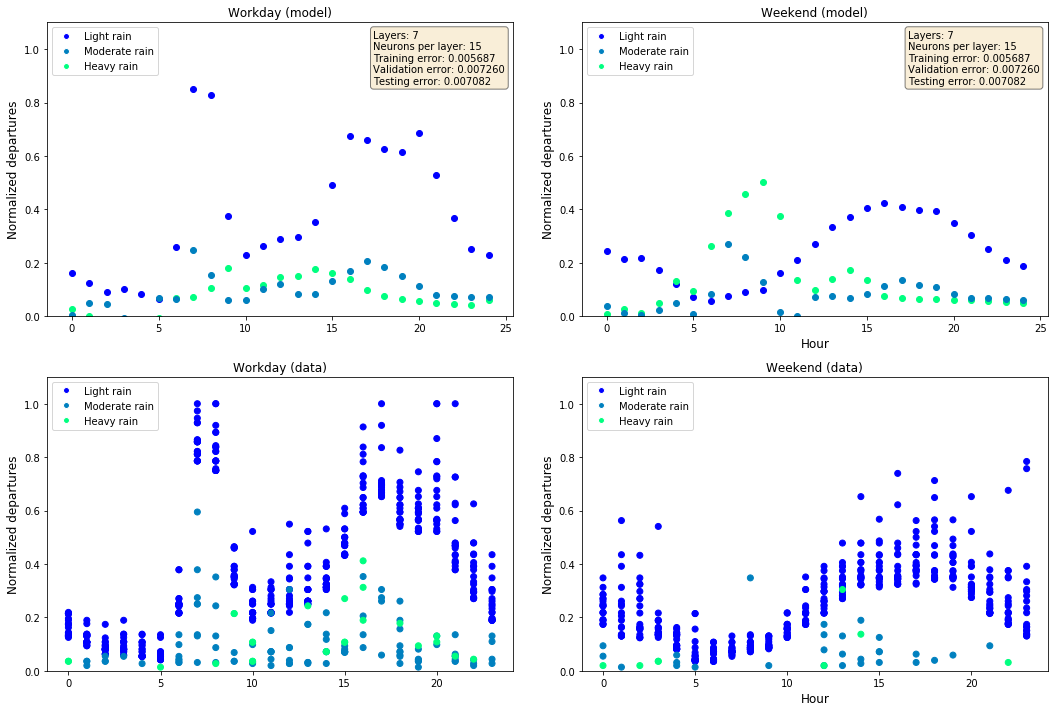

In [37]:
simulated_data_workday = np.array([[0, i, 0] for i in range(25)]).reshape(-1 , 3)
simulated_data_weekend = np.array([[1, i, 0] for i in range(25)]).reshape(-1 , 3)
simulated_data_workday_raining = np.array([[0, i, 2] for i in range(25)]).reshape(-1 , 3)
simulated_data_weekend_raining = np.array([[1, i, 2] for i in range(25)]).reshape(-1 , 3)
simulated_data_workday_raining_2 = np.array([[0, i, 1] for i in range(25)]).reshape(-1 , 3)
simulated_data_weekend_raining_2 = np.array([[1, i, 1] for i in range(25)]).reshape(-1 , 3)

predicted_data_workday = mlp_regr.predict(simulated_data_workday)
predicted_data_weekend = mlp_regr.predict(simulated_data_weekend)
predicted_data_workday_raining = mlp_regr.predict(simulated_data_workday_raining)
predicted_data_weekend_raining = mlp_regr.predict(simulated_data_weekend_raining)
predicted_data_workday_raining_2 = mlp_regr.predict(simulated_data_workday_raining_2)
predicted_data_weekend_raining_2 = mlp_regr.predict(simulated_data_weekend_raining_2)

mask_weekday = (X_train[:, 0] == 0)
mask_weekend = (X_train[:, 0] == 1)

mask_weekday_data = (X[:, 0] == 0)
mask_weekend_data = (X[:, 0] == 1)

fig, axs = plt.subplots(2, 2)
fig.set_figwidth(15)
fig.set_figheight(10)
cmap = plt.cm.winter
axs[0, 0].scatter(simulated_data_workday[:, 1], predicted_data_workday, c=cmap(0.0))
axs[0, 0].set_ylim(0, 1.1)
axs[0, 1].scatter(simulated_data_weekend[:, 1], predicted_data_weekend, c=cmap(0.0))
axs[0, 1].set_ylim(0, 1.1)
axs[0, 0].scatter(simulated_data_workday_raining[:, 1], predicted_data_workday_raining, c=cmap(1.0))
axs[0, 1].scatter(simulated_data_weekend_raining[:, 1], predicted_data_weekend_raining, c=cmap(1.0))
axs[0, 0].scatter(simulated_data_workday_raining_2[:, 1], predicted_data_workday_raining_2, c=cmap(0.5))
axs[0, 1].scatter(simulated_data_weekend_raining_2[:, 1], predicted_data_weekend_raining_2, c=cmap(0.5))

custom_markers = [Line2D([0], [0], color="w", markerfacecolor=cmap(0.0), marker='o'),
                  Line2D([0], [0], color="w",
                         markerfacecolor=cmap(0.5), marker='o'),
                  Line2D([0], [0], color="w", markerfacecolor=cmap(1.0), marker='o')]
axs[0, 0].legend(custom_markers, ["Light rain", "Moderate rain", "Heavy rain"], loc='upper left', prop={'size':10})
axs[0, 1].legend(custom_markers, ["Light rain", "Moderate rain", "Heavy rain"], loc='upper left', prop={'size':10})

axs[0, 0].set_ylabel("Normalized departures", fontsize=12)
axs[0, 1].set_ylabel("Normalized departures", fontsize=12)
axs[0, 1].set_xlabel("Hour", fontsize=12)
axs[0, 0].set_title("Workday (model)", fontsize=12)
axs[0, 1].set_title("Weekend (model)", fontsize=12)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
text_str = "Layers: {:d}".format(num_layers) + "\nNeurons per layer: {:d}".format(num_neurons) + "\nTraining error: {:.6f}".format(tr_error) + "\nValidation error: {:.6f}".format(val_error) + "\nTesting error: {:.6f}".format(test_error)
axs[0, 0].text(0.7, 0.975, text_str, transform=axs[0, 0].transAxes,fontsize=10, verticalalignment="top", bbox=props)
axs[0, 1].text(0.7, 0.975, text_str, transform=axs[0, 1].transAxes,fontsize=10, verticalalignment="top", bbox=props)

axs[1, 0].scatter(X[:, 1][mask_weekday_data], y[mask_weekday_data], c=X[:,2][mask_weekday_data], cmap='winter')
axs[1, 1].scatter(X[:, 1][mask_weekend_data], y[mask_weekend_data], c=X[:,2][mask_weekend_data], cmap='winter')
axs[1, 0].set_ylabel("Normalized departures", fontsize=12)
axs[1, 1].set_ylabel("Normalized departures", fontsize=12)
axs[1, 1].set_xlabel("Hour", fontsize=12)
axs[1, 0].set_title("Workday (data)", fontsize=12)
axs[1, 1].set_title("Weekend (data)", fontsize=12)
axs[1, 0].set_ylim(0.0, 1.1)
axs[1, 1].set_ylim(0.0, 1.1)
cmap = plt.cm.winter
custom_markers = [Line2D([0], [0], color="w", markerfacecolor=cmap(0.0), marker='o'),
                  Line2D([0], [0], color="w",
                         markerfacecolor=cmap(0.5), marker='o'),
                  Line2D([0], [0], color="w", markerfacecolor=cmap(1.0), marker='o')]
axs[1, 0].legend(custom_markers, ["Light rain", "Moderate rain", "Heavy rain"], loc='upper left', prop={'size':10})
axs[1, 1].legend(custom_markers, ["Light rain", "Moderate rain", "Heavy rain"], loc='upper left', prop={'size':10})

plt.tight_layout()
plt.savefig("mlp_results.jpg", dpi=300, bbox_inches="tight")
plt.show()




And tada, we have modeled the number of departures not only based on the hour of day, but also the type of day and rain! 

The workday plot seems pretty good, but the weekend plot has an odd peak in the morning when it rains. This might be due to an outlier in the rain data combined with a lot of missing rain data. I guess the only thing to do is to hope for some rainy weekends in the summer to improve on this! 😁😁